# 线性回归_房价预测任务
## 一个简化模型

- 假设一： 影响房价的关键因素是卧室的个数、卫生间的格式和居住面积
- 假设二： 成交价是关键因素的加权和

$$
y=w_1 x_1 + w_2 x_2 + w_3 x_3 + b
$$ 
权重和偏差的实际值在后面决定



## 线性模型

- 给定n维输入 $x=[x_1 , x_2 , ... , x_n]^T$
- 线性模型有一个n维权重和一个标量偏差$$w=[w_1 , w_2 ,...,w_n]^T, b$$
- 输出是输入的加权和$$y=w_1 x_1 + w_2 x_2+...+w_n x_n + b$$
- 向量版本$$y = <w,x> + b$$
- 线性模型可以看作是一个单层神经网络



## 衡量预估质量
- 比较真实值和预估值，例如房屋售价和估价
- 假设$y$是真实值，$\hat{y}$是估计值，我们可以比较 $$l(y,\hat{y})=\frac{1}{2}(y-\hat{y})^2$$ 这个叫做平方损失



## 训练数据
- 收集一些数据点来决定参数值(权重和偏差)，例如过去六个月卖的房子
- 这些被称之为训练数据
- 通常越多越好
- 假设我们有n个样本，记 $$X=[x_1 , x_2 , ... , x_n]^T 和 y=[y_1 , y_2 ,..., y_n]^T$$



## 参数学习

- 训练损失 $$l(X,y,w,b)=\frac{1}{2n} \sum^{n}_{2n}{(y_i <x_i ,w>-b)^2} = \frac{1}{2n}||y-Xw-b||^2$$
- 最小化损失来学习参数 $$w^* ,b^* = \arg{\min_{W,b}{l(X,y,w,b)}}$$

## 显示解

- 偏差加入权重 $X \leftarrow[X,1]和w\leftarrow [w,b]^T$ $$l(X,y,w)=\frac{1}{2n} ||y-Xw||^2 ,偏导：\frac{\partial}{\partial w}l(X,y,w)=\frac{1}{n}(y-Xw)^T X$$
- 损失函数是凸函数，所以最优解满足：$$\frac{\partial}{\partial w}l(X,y,w)=0 \\ \Leftrightarrow \frac{1}{n}(y-Xw)^T X=0 \\ \Leftrightarrow w^*=(X^T X )^{-1}Xy$$

## 总结
- 线性回归是对n维输入的加权，外加偏差
- 使用平方损失来衡量与测试值和真实值地方差异
- 线性回归有显示解
- 线性回归可以看作是单层神经网络

# 基础优化算法

## 梯度下降
- 挑选一个初始值$w_0$
- 重复迭代参数$t=1,2,3$ $$w_t = w_{t-1} -\eta \frac{\partial{l}}{\partial w_{t-1}}$$
- 沿梯度方向将增加损失函数值
- 学习率：步长的超参数



## 选择学习率
- 不能太小：步长有限需要太多步骤
- 不能太大：步长过大会导致结果一直震荡无法成功



## 小批量随机梯度下降
- 在整个训练集上算梯度太贵
  - 在一个深度神经网路模型可能需要数分钟至数小时
- 我们可以随机采样b个样本$i_1, i_2,…, i_b$来接近损失 $$ \frac{1}{b}\sum_{i\in I_b}{l(x_i , y_i , w)}$$
  - b是批量大小，另一个重要的超参数
- 批量大小
  - 不能太大：不适合并行来最大利用计算资源
  - 不能太大：内存消耗增加，浪费计算资源



## 总结
- 梯度下降通过不断沿着反梯度方向更新参数求解
- 小批量随机梯度下降是深度学习默认的求解算法
- 两个重要的超参数是批量大小和学习率

# 线性回归的从零开始实现

流水线、模型、损失函数、小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch

## 生成数据集
根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$w=[2,3,-4]^T、b=4.2$和噪声项$\epsilon$生成数据集及其标签：$$y=Xw+b+\epsilon$$

In [2]:
def synthetic_data(w,b,num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples,len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

## features
每一行都包含一个二维数据数据样本，labels中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.2267,  0.7970]) 
label: tensor([1.0254])


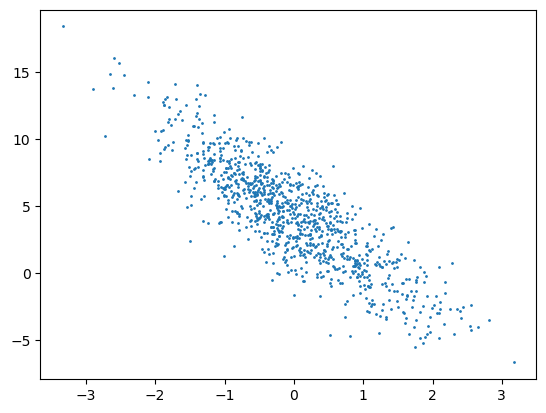

In [4]:
import matplotlib.pylab as plt
# detach()分离出数值，不在含有梯度
plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1)
plt.show()

## 小批量batch
定义一个`data_iter`函数，该函数接收批量大小、矩阵特征和标签向量作为输入，生成`batch_size`的小批量

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本，无特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X,'\n',y)
    break

tensor([[ 0.1880, -0.6219],
        [-0.8477,  0.0240],
        [ 0.0838, -0.4730],
        [ 0.0949, -0.2394],
        [ 0.2814,  1.2706],
        [-0.2651, -0.0408],
        [-0.5344, -0.8065],
        [ 0.4545, -0.4772],
        [ 0.1543,  2.1143],
        [ 0.1255, -0.4825]]) 
 tensor([[ 6.6808],
        [ 2.4198],
        [ 5.9697],
        [ 5.2027],
        [ 0.4576],
        [ 3.8088],
        [ 5.8805],
        [ 6.7209],
        [-2.6790],
        [ 6.0811]])


## 初始化参数模型

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [14]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    """均方损失"""
    return(y_hat - y.reshape(y_hat.shape))**2/2

## 定义优化方法

In [12]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练过程

In [15]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features,labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为'l'的形状是('batch_size',1)，而不是一个标量。'l'中的所有元素被加到一起
        # 并以此计算关于['w', 'b']的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')

epoch 1, loss 0.038230
epoch 2, loss 0.000148
epoch 3, loss 0.000053
